In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

#### 1. Load the Dataset

In [42]:
df_fake = pd.read_csv('Fake.csv')
df_fake['label'] = 0  # fake - 0

df_real  = pd.read_csv('True.csv')
df_real['label'] = 1 # real - 1

# combine and shuffle 
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head(15)

print(df['label'].value_counts())

label
0    23481
1    21417
Name: count, dtype: int64


#### 2. Data Preprocessing

In [43]:
def data_qualityCheck():
    print("Checking data qualitites...")
    df.isnull().sum()
    df.info()  
    df.shape
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
check finished.


C:\Users\gaura\AppData\Local\Temp\ipykernel_20536\809431606.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subject_percentages.index, y=subject_percentages.values, palette='Set2')


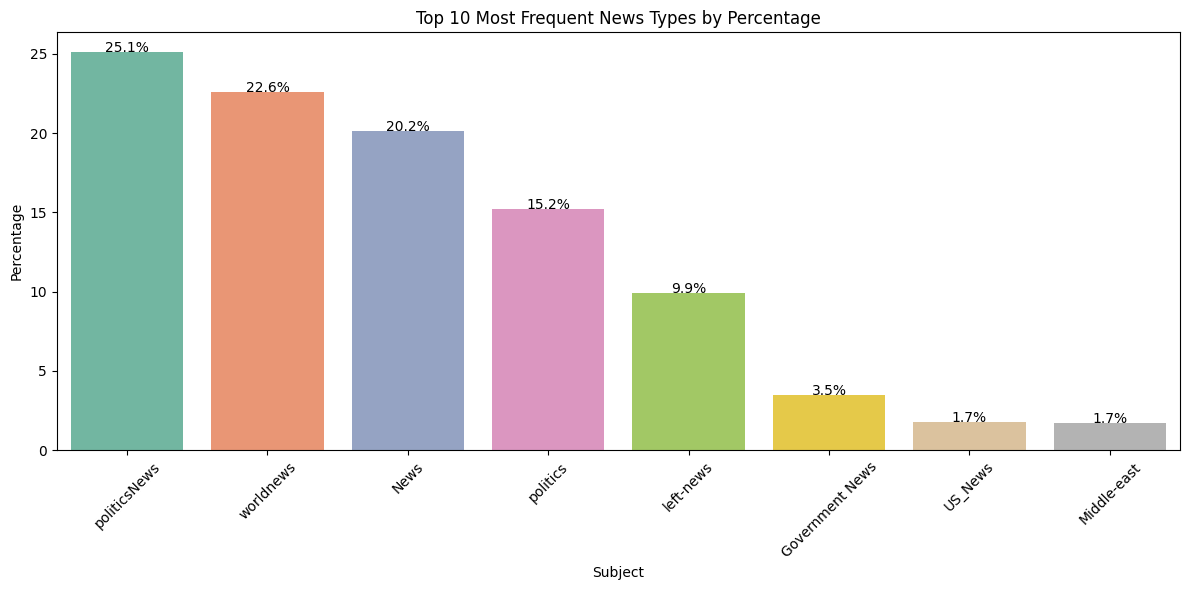

In [44]:
# Get top 10 subjects by count
subject_counts = df['subject'].value_counts().head(10)
subject_percentages = (subject_counts / len(df)) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=subject_percentages.index, y=subject_percentages.values, palette='Set2')

# Add percentage labels on top of each bar
for index, value in enumerate(subject_percentages.values):
    plt.text(index, value, f'{value:.1f}%', ha='center', fontsize=10, color='black')

plt.title("Top 10 Most Frequent News Types by Percentage")
plt.xlabel("Subject")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
# drop irrelevant columns 
df = df.drop(['subject', 'date'], axis=1)

# combine title and text into a single column 
df['content'] = df['title'] + " " + df['text']

# Drop the original title and text column 
df = df.drop(['title', 'text'], axis=1)

# check the shape and null values 
print(df.shape)
print(df.isnull().sum())

print(df.head(5))

(44898, 2)
label      0
content    0
dtype: int64
   label                                            content
0      1  'Consistent' pattern of crimes against Myanmar...
1      0  OBAMA GUILTS CONGRESSIONAL BLACK CAUCUS Member...
2      0  Hannity Interview with Julian Assange: Wikilea...
3      0   Elementary School Goes On Lockdown After Righ...
4      1  Trump said 'we'll see' when asked whether U.S....


#### 3. EDA

C:\Users\gaura\AppData\Local\Temp\ipykernel_20536\166014236.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  return sns.countplot(x='label', data=dataFile, palette='hls')


<Axes: xlabel='label', ylabel='count'>

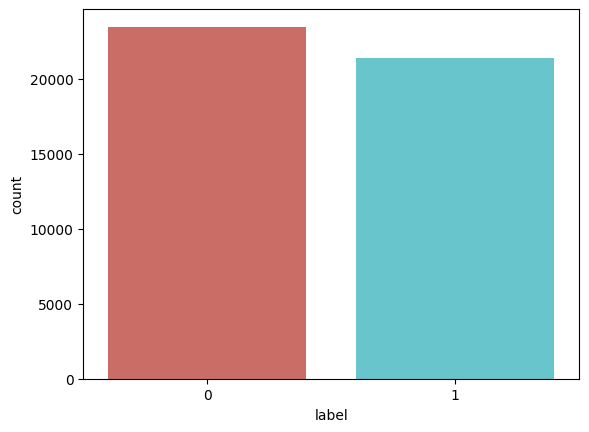

In [46]:
def create_distribution(dataFile):
    return sns.countplot(x='label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(df)

### 4. Text Preprocessing

In [47]:
stop_words = list(set(stopwords.words('english'))) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@[\w]+|\#','', text)  # Keep named entities
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove only special characters
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(filtered_tokens)

# Apply the cleaning function
df['content'] = df['content'].apply(clean_text)

# Preview the cleaned data
print(df['content'].head())

0    consistent pattern crime myanmar rohingya expe...
1    obama guilt congressional black caucus member ...
2    hannity interview julian assange wikileaks sou...
3    elementary school go lockdown rightwing dad th...
4    trump said well see asked whether would attack...
Name: content, dtype: object


#### 5. Feature Extraction

In [48]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X = vectorizer.fit_transform(df['content']).toarray()
y = df['label']

#### 6. Train-Test Split


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
X.shape, y.shape

((44898, 10000), (44898,))

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((35918, 10000), (35918,), (8980, 10000), (8980,))

#### 7. Model Training


In [52]:
# Train Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#### 8. Model Evaluation

In [53]:
# Prediction with Logistic Regression
y_pred = model.predict(X_test)

# Evaluate
print(f'Accuracy Score: {round(accuracy_score(y_test, y_pred)*100, 2)}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 99.11%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [54]:
y_pred

array([1, 1, 0, ..., 1, 1, 0], shape=(8980,))

In [55]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, figsize=(6,4), cmap='Blues'):
    """
    Plots a confusion matrix heatmap.

    Parameters:
    - y_true: array-like of shape (n_samples,) - True labels
    - y_pred: array-like of shape (n_samples,) - Predicted labels
    - class_names: list of strings, optional - Class names to label axes
    - figsize: tuple, optional - Figure size
    - cmap: string, optional - Color map for heatmap
    
    Returns:
    - None (shows the plot)
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

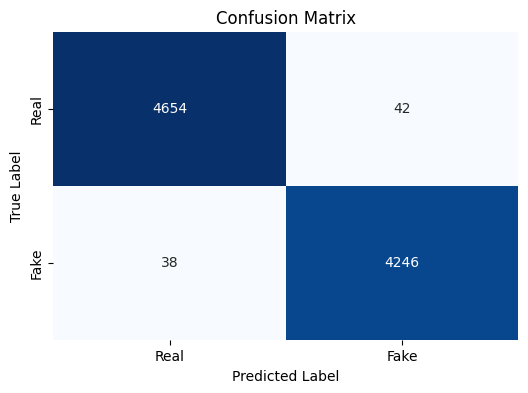

In [56]:
class_names = ['Real', 'Fake']

plot_confusion_matrix(y_test, y_pred, class_names)

In [57]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [58]:
# Load the model from disk 
load_model = pickle.load(open('model.pkl', 'rb'))

In [59]:
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

### Naive Bayes 

In [ ]:
# Train Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

MultinomialNB()

In [61]:
y_pred_nb = model_nb.predict(X_test) # prediction with Naive Bayes
y_pred_nb

array([1, 1, 0, ..., 1, 1, 0], shape=(8980,))

In [62]:
print("Confusion Matrix for Naive Bayes:")
confusion_matrix_nb = confusion_matrix(y_test,y_pred_nb)
confusion_matrix_nb

Confusion Matrix for Naive Bayes:


array([[4462,  234],
       [ 213, 4071]])

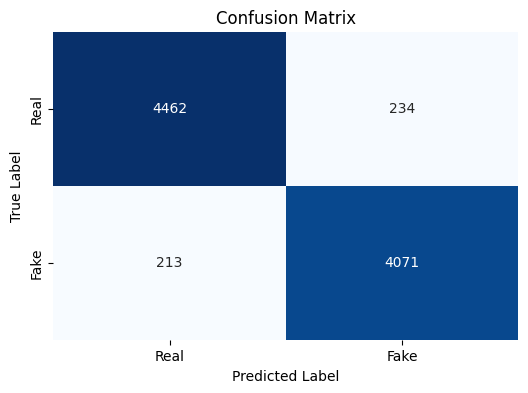

In [63]:
plot_confusion_matrix(y_test, y_pred_nb, class_names)

In [64]:
# Evaluate
print(f'Accuracy Score: {round(accuracy_score(y_test, y_pred_nb)*100, 2)}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Accuracy Score: 95.02%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      4696
           1       0.95      0.95      0.95      4284

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



#### Decision Trees

In [ ]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [66]:
y_pred_dt = model_dt.predict(X_test) # prediction with Decision Tree
y_pred_dt

array([1, 1, 0, ..., 0, 1, 0], shape=(8980,))

In [67]:
# Evaluate
print(f'Accuracy Score: {round(accuracy_score(y_test, y_pred_dt)*100, 2)}%')
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Accuracy Score: 99.51%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      4696
           1       1.00      0.99      0.99      4284

    accuracy                           1.00      8980
   macro avg       1.00      0.99      1.00      8980
weighted avg       1.00      1.00      1.00      8980



#### KNN

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train,y_train)

KNeighborsClassifier()

In [69]:
y_pred_KNN = model_knn.predict(X_test) # prediction with KNN
y_pred_KNN

array([1, 0, 0, ..., 0, 0, 0], shape=(8980,))

In [70]:
print("Accuracy Score: ", round(accuracy_score(y_test, y_pred_KNN)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_KNN))

Accuracy Score:  70.4 %

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.98      0.78      4696
           1       0.95      0.40      0.56      4284

    accuracy                           0.70      8980
   macro avg       0.80      0.69      0.67      8980
weighted avg       0.79      0.70      0.67      8980



### SVM

In [ ]:
model_svm = SVC(kernel='linear')
model_svm.fit(X_train,y_train)

SVC(kernel='linear')

In [72]:
y_pred_svm = model_svm.predict(X_test) # prediction with SVM
y_pred_svm

array([1, 1, 0, ..., 1, 1, 0], shape=(8980,))

In [73]:
print("Accuracy Score: ", round(accuracy_score(y_test, y_pred_svm)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Accuracy Score:  99.55 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



## Comparison of Accuracy Score of Different Models

C:\Users\gaura\AppData\Local\Temp\ipykernel_20536\300337901.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df, palette='Set1')


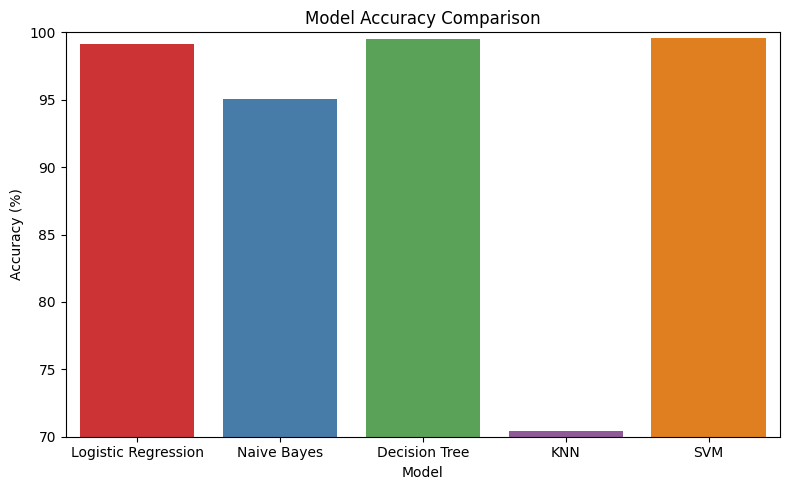

<Figure size 640x480 with 0 Axes>

In [74]:
# Create a DataFrame for model names and their accuracy scores
df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'KNN', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred)*100,
        accuracy_score(y_test, y_pred_nb)*100,
        accuracy_score(y_test, y_pred_dt)*100,
        accuracy_score(y_test, y_pred_KNN)*100,
        accuracy_score(y_test, y_pred_svm)*100
    ]
})


# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=df, palette='Set1')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(70, 100)
plt.tight_layout()
plt.show()
plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')

In [5]:
def output_label(n):
    if n == 0:
        return "Fake News"
    else:
        return "Real News"


def manual_testing(news):
    testing_news = {"text": [news]}
    news_def_test = pd.DataFrame(testing_news)
    news_def_test['content'] = news_def_test['text'].apply(clean_text)
    new_x_test = news_def_test['content']
    new_xv_test = vectorizer.transform(new_x_test)
    pred_LR = model.predict(new_xv_test)
    pred_NB = model_nb.predict(new_xv_test)
    pred_DT = model_dt.predict(new_xv_test)
    pred_KNN = model_knn.predict(new_xv_test)
    pred_SVM = model_svm.predict(new_xv_test.toarray())
    

    return print("\n\n LR Prediction: {} \n NB Prediction: {} \n DT Prediction: {} \n KNN Prediction: {} \n SVM Prediction: {}".format(output_label(pred_LR[0]),output_label(pred_NB[0]),output_label(pred_DT[0]),output_label(pred_KNN[0]),output_label(pred_SVM[0])))

In [80]:
news = str(input())
manual_testing(news)



 LR Prediction: Fake News 
 NB Prediction: Real News 
 DT Prediction: Fake News 
 KNN Prediction: Fake News 
 SVM Prediction: Fake News
